# Description

This script will run the Sparse Box-Constrained Non-Negative Matrix Factorization on the 11 self-report questions (excluding wakefulness). This is the version that separately applies sparsity to the Q and W matrices and that also accounts for potential demographics condounds.

Before running this notebook, you need to run Notebook S11 to decide on the best hyper-paramteres (e.g., dimensionality and sparsity values)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import holoviews as hv
from holoviews import opts
from scipy.stats import ttest_ind, mannwhitneyu
import panel as pn
from wordcloud import WordCloud
import hvplot.pandas
from IPython.display import Markdown as md

In [2]:
from matplotlib import rc
font_dict = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}
rc('font', **font_dict)

In [3]:
from dataclasses import dataclass

In [4]:
@dataclass
class matrix_class:

    M : np.ndarray # (column)-normalized data matrix
    M_raw : np.ndarray # raw data matrix
    confound : np.ndarray # normalized confounder matrix
    confound_raw : np.ndarray # raw confounder matrix
    nan_mask : np.ndarray # mask matrix for missing entires (0=missing, 1=available)
    row_idx : np.ndarray # global row index (for multiple data matrices)
    col_idx : np.ndarray # global column index (for multiple data matrices)
    mask : np.ndarray # global mask (for multiple data matrices)
    dataname : str # dataname
    subjlist : list # information on subjects (row information)
    itemlist : list # information on items (column information)
    W : np.ndarray # subject embedding (recall M = [W, C]Q^T)
    Q : np.ndarray # item embedding (recall M = [W, C]Q^T)
    C : np.ndarray # confounder matrix
    Qc : np.ndarray # confounders' loadings (recall Q = [RQ, CQ])
    Z : np.ndarray # auxiliary Z=WQ^T (ADMM)
    aZ : np.ndarray # auxiliary variables (ADMM)

In [5]:
import sys
sys.path.append('./mlt/')
from method.ICQF.ICQF import ICQF

In [6]:
from utils.basics import get_sbj_scan_list, SNYCQ_Questions, SNYCQ_Question_type, SNYCQ_CLUSTERS_INFO_PATH, DATA_DIR
from utils.SNYCQ_NMF_Extra import plot_Q_bars, cluster_scans, plot_W, plot_W_scatter, plot_P,plot_W_heatmap

# 1. Load list of Scans, Subjects and the SNYCQ dataframe

Get list of scans, subjects and the SNYCQ dataframe for the data entering the analyses

In [7]:
SBJs, SCANs, SNYCQ = get_sbj_scan_list(when='post_motion', return_snycq=True)

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


Remove the Vigilance/Wakefulness Question from the dataframe

In [8]:
SNYCQ = SNYCQ.drop('Vigilance',axis=1)
Nscans, Nquestions = SNYCQ.shape
print(SNYCQ.shape)

(471, 11)


# 2. Apply Sparse Box-Constrained Non-Negative Factorization to the SNYCQ dataframe

The line below will run the algorithm with the following hyper-parameters:

* Attempt Demographic Confound Modeling is `True`
* W bounded to range `[0,1]`
* Q bounded to range `[0,100]`
* W sparsity is `0.0`
* Q sparsity is `0.01`
* Number of maximum iterations is `200`
* Dimensionality is `2`

In [10]:
data  = np.load('./mlt/output/full_data.npz')
M_arr = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
MF_data = matrix_class(M_arr, None, confound, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)
DIM=2
clf = ICQF(DIM, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.01,
                        max_iter=200)
MF_data, loss_list = clf.fit_transform(MF_data)

Sanity check to ensure that the inputs used in the hyper-parameter exploration and here on the final application of the algorithm are the same

In [19]:
M = SNYCQ.values.astype('float')
print('Range of data matrix M:      [min={}, max={}]'.format(np.min(M), np.max(M)))
print('Dimensions of data matrix M: [#scans={}, #questions={}]'.format(M.shape[0],M.shape[1]))
assert np.sum(np.isnan(M)) == 0 # Make sure there are no missing values
assert np.all(M_arr==M), "Input to algorithm based on data given to MLT and mine are NOT the same"

Range of data matrix M:      [min=0.0, max=100.0]
Dimensions of data matrix M: [#scans=471, #questions=11]


# 2.1. Convert outputs to DataFrames with meaningful indexing for plotting

In [20]:
W = pd.DataFrame(MF_data.W, index=SNYCQ.index, columns=['Factor {d}'.format(d=d+1) for d in range(DIM)])
Q = pd.DataFrame(MF_data.Q, index=SNYCQ.columns, columns=['Factor {d}'.format(d=d+1) for d in range(DIM)])
C = pd.DataFrame(MF_data.C, index=SNYCQ.index, columns=['Age (elder)','Gender (M)','Age (younger)','Gender (F)','Intercept'])
C = C[['Intercept','Age (younger)','Age (elder)','Gender (M)','Gender (F)']] # Sorting to make it more interpretable
Qc = pd.DataFrame(MF_data.Qc, index=SNYCQ.columns, columns = ['Age (elder)','Gender (M)','Age (younger)','Gender (F)','Intercept'])
Qc = Qc[['Intercept','Age (younger)','Age (elder)','Gender (M)','Gender (F)']] # Sorting to make it more interpretable

# 3. Plot the different outputs from the algorithm

First, we will plot the W matrix (low dimensional represenation of interest) and the Qc matrix (encoding of the demographic data)

In [29]:
W_plot_unsroted = W.reset_index(drop=True).hvplot.heatmap(cmap='Greens', width=300, height=500, fontscale=1.2, clim=(0,1)).opts( colorbar_opts={'title':'W Matrix'}, xrotation=90, toolbar=None)
C_plot_unsorted = C.reset_index(drop=True).hvplot.heatmap(cmap='Purples', width=300, height=500, fontscale=1.2).opts( colorbar_opts={'title':'C Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(W_plot_unsroted,C_plot_unsorted)
f.save('./figures/W_and_C_unsorted.png')
text="![](./figures/W_and_C_unsorted.png)"
md("%s"%(text))

![](./figures/W_and_C_unsorted.png)

Next, we will plot the Q matrix (with relationships between questions and low dimensional factors) and the Qc matrix (with information about how responses relate to demographics)

In [26]:
Q_plot_unsorted  = Q.hvplot.heatmap( cmap='Oranges', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90, toolbar=None)
Qc_plot_unsorted = Qc.hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_unsorted, Qc_plot_unsorted)
f.save('./figures/Q_and_Qc_unsorted_same_scale.png')
f

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=300)
    [1] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=300)

In [14]:
Q_plot_unsorted  = Q.hvplot.heatmap( cmap='Oranges', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90, toolbar=None)
Qc_plot_unsorted = Qc.hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,10), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_unsorted, Qc_plot_unsorted)
f.save('./figures/Q_and_Qc_unsorted_diff_scale.png')

In [15]:
sorted_q = Q.sort_values(by=['Factor 1','Factor 2'],ascending=False).index
Q_plot_unsorted  = Q.loc[sorted_q].hvplot.heatmap( cmap='Oranges', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90, toolbar=None)
Qc_plot_unsorted = Qc.loc[sorted_q].hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,10), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_unsorted, Qc_plot_unsorted)
f.save('./figures/Q_and_Qc_sorted_diff_scale.png')

In [91]:
sorted_q = Q.sort_values(by=['Factor 1','Factor 2'],ascending=False).index
Q_plot_unsorted  = Q.loc[sorted_q].hvplot.heatmap( cmap='Oranges', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90, toolbar=None)
Qc_plot_unsorted = Qc.loc[sorted_q].hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_unsorted, Qc_plot_unsorted)
f.save('./figures/Q_and_Qc_sorted_same_scale.png')

In [16]:
f = pn.Row(W.reset_index(drop=True).hvplot.heatmap(cmap='Greens', ylabel='Scans', width=250, height=500, fontscale=1.2, clim=(0,1)).opts( colorbar_opts={'title':'W Matrix'}, xrotation=90, toolbar=None))
f.save('./figures/W_unsorted.png')
f

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=250)

In [85]:
Q.loc[sorted_q].hvplot.heatmap(width=275,height=400,cmap='Oranges', clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90)

:HeatMap   [columns,index]   (value)

In [90]:
Qc.hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)

:HeatMap   [columns,index]   (value)

In [18]:
Q['Factor 2'].to_dict()

{'Positive': 0.0,
 'Negative': 60.201252391106074,
 'Future': 6.943619516773143,
 'Past': 16.250478514971093,
 'Myself': 53.2546938260027,
 'People': 0.0,
 'Surroundings': 74.7039997152589,
 'Images': 0.0,
 'Words': 52.645133692477685,
 'Specific': 2.7539595024531143,
 'Intrusive': 32.879625815451}

In [19]:
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

(-0.5, 299.5, 299.5, -0.5)

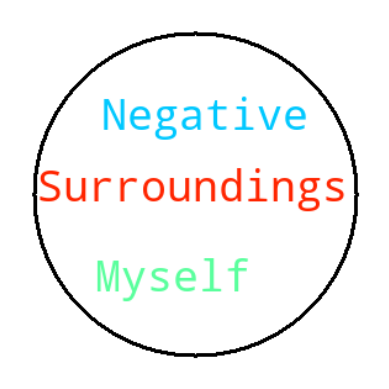

In [20]:
wc = WordCloud(max_font_size=50, width=200, height=200,contour_color='black', contour_width=3, colormap='jet',max_words=3, background_color='white', repeat=True, mask=mask).fit_words(Q['Factor 2'].to_dict())
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 299.5, 299.5, -0.5)

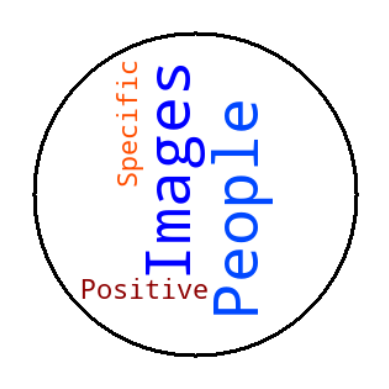

In [21]:
wc = WordCloud(max_font_size=50, width=200, height=200,contour_color='black', contour_width=3, colormap='jet',max_words=4, background_color='white', repeat=True, mask=mask).fit_words(Q['Factor 1'].to_dict())
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [22]:
Precon = pd.DataFrame(np.dot(W,Q.T),index=SNYCQ.index,columns=SNYCQ.columns)

***

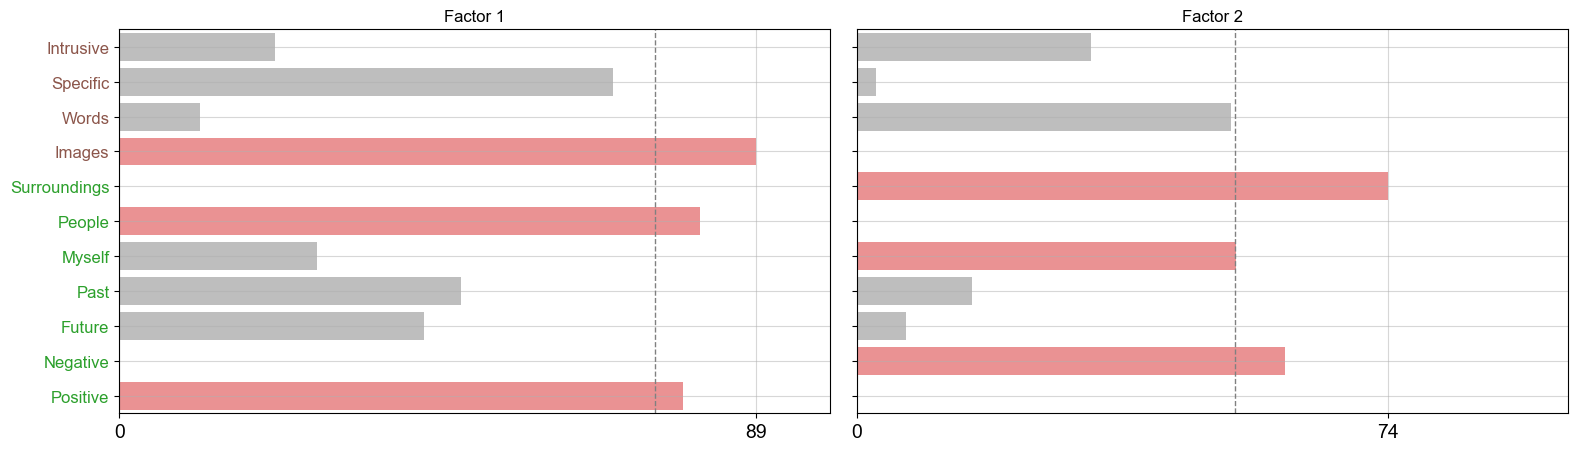

In [23]:
plot_Q_bars(Q,SNYCQ,SNYCQ_Questions, SNYCQ_Question_type)

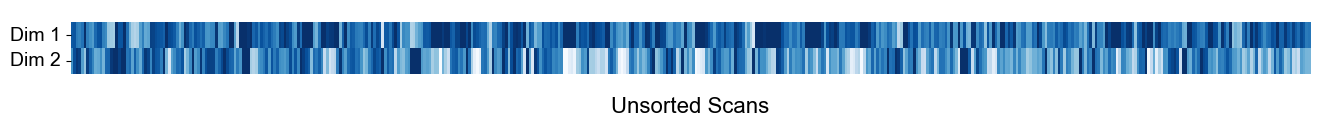

In [24]:
plot_W(W)

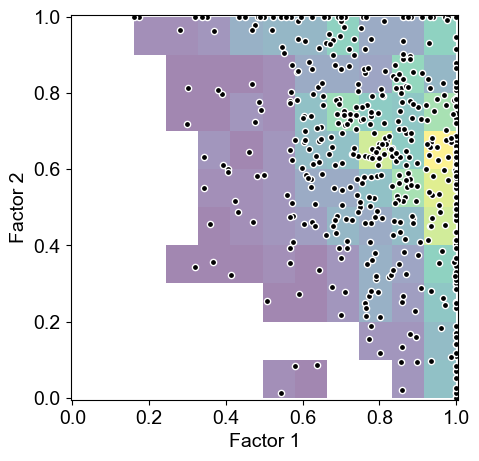

In [25]:
f = plot_W_scatter(W, plot_hist=True, plot_kde=False, figsize=(5,5), marker_size=20)
f

In [26]:
f.savefig('./figures/bcm_embedding.png')

In [28]:
top_left_scans = W[(W['Factor 1']<0.4) & (W['Factor 2']>0.9)].index
a = SNYCQ.loc[top_left_scans].reset_index(drop=True)
a.index = a.index.astype(str)
a[sorted_q].hvplot.heatmap(width=250, height=250, clim=(0,100), cmap='Viridis', ylabel='Scan', xlabel='Question', fontscale=1.2).opts(colorbar=False, xrotation=90)

:HeatMap   [columns,index]   (value)

In [29]:
top_left_scans = W[(W['Factor 1']>0.75) & (W['Factor 1']<0.94) & (W['Factor 2']<0.2)].index
a = SNYCQ.loc[top_left_scans].reset_index(drop=True)
a.index = a.index.astype(str)
a[sorted_q].hvplot.heatmap(width=250, height=250, clim=(0,100), cmap='Viridis', ylabel='Scan', xlabel='Question', fontscale=1.2).opts(colorbar=False, xrotation=90)

:HeatMap   [columns,index]   (value)

***
# Automatic Clustering

In [32]:
N_CLUSTERS = 3
cluster_ids = cluster_scans(W, n_clusters=N_CLUSTERS)
cluster_ids = cluster_ids.astype(int)
print('++ INFO: Number of clusters = %d' % int(cluster_ids.max()+1))

++ INFO [cluster_scans]: Doing agglomerative clustering for provied k = 3
++ INFO: Number of clusters = 3


In [33]:
clusters_info = pd.DataFrame(index=W.index, columns=['Cluster ID','Cluster Label'])
clusters_info['Cluster ID'] = cluster_ids

In [34]:
cluster_labels_translate = {x:'Middle' for x in np.unique(cluster_ids)}
Waux = W.copy()
Waux['Cluster ID']    = cluster_ids
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 1', ascending=False).iloc[0].name)] = 'Large F1'
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 2', ascending=False).iloc[0].name)] = 'Large F2'
clusters_info['Cluster Label'] = [cluster_labels_translate[c] for c in Waux['Cluster ID']]
clusters_info['Cluster ID'] = 0
clusters_info.loc[clusters_info['Cluster Label']=='Large F1','Cluster ID'] = 1
clusters_info.loc[clusters_info['Cluster Label']=='Large F2','Cluster ID'] = 2
clusters_info.loc[clusters_info['Cluster Label']=='Middle'  ,'Cluster ID'] = 3
del Waux, cluster_ids, cluster_labels_translate

In [35]:
clusters_info.value_counts('Cluster Label')

Cluster Label
Middle      312
Large F1     81
Large F2     78
dtype: int64

In [36]:
sbjs = clusters_info.index.get_level_values('Subject').unique()
df = pd.DataFrame(index=sbjs, columns=['Num Scans','Large F1','Large F2','Middle'])
for sbj in sbjs:
    aux = clusters_info.loc[sbj,:]
    df.loc[sbj,'Num Scans'] = aux.shape[0]
    aux_counts = aux['Cluster Label'].value_counts()
    for cl in ['Large F1','Large F2','Middle']:
        if cl in aux_counts:
            df.loc[sbj,cl] = aux_counts[cl]
        else:
            df.loc[sbj,cl] = 0

In [37]:
df.head(5)

,Num Scans,Large F1,Large F2,Middle
Subject,,,,
sub-010014,4,0,2,2
sub-010080,2,1,0,1
sub-010082,3,0,2,1
sub-010084,4,0,0,4
sub-010015,4,0,4,0


In [38]:
['%d subjects have %d scans' % (df.set_index('Num Scans').loc[n+1].shape[0], n+1) for n in range(4)]

['7 subjects have 1 scans',
 '10 subjects have 2 scans',
 '20 subjects have 3 scans',
 '96 subjects have 4 scans']

In [39]:
clustering_summary = pd.Series(dtype=int, name='Clustering Consistency')
clustering_summary['Total in Sample'] = len(sbjs)
df = df[df['Num Scans']>2]
clustering_summary['With multiple scans']              = df.shape[0]
clustering_summary['All scans in single cluster']      = ((df==0).sum(axis=1)==2).sum()
clustering_summary['All but 1 scan in single cluster'] = (df['Num Scans']-df.drop('Num Scans', axis=1).max(axis=1) == 1.0).sum()
clustering_summary['Others'] = (df['Num Scans']-df.drop('Num Scans', axis=1).max(axis=1) > 1.0).sum()
clustering_summary

Total in Sample                     133
With multiple scans                 116
All scans in single cluster          54
All but 1 scan in single cluster     42
Others                               20
Name: Clustering Consistency, dtype: int64

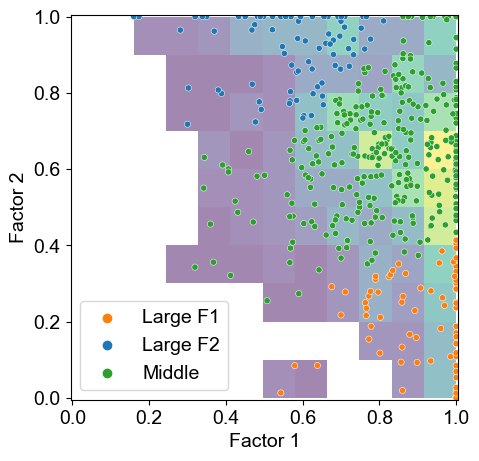

In [58]:
f = plot_W_scatter(W, clusters_info=clusters_info, plot_kde=False, plot_hist=True, marker_size=20,figsize=(5,5), cluster_palette=[(1.0, 0.4980392156862745, 0.054901960784313725),
                                                                                                                                  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),])
f

In [59]:
f.savefig('./figures/bcm_embedding_withclusters.png')

In [60]:
a = W.copy()
a = a.reset_index()
a = a.infer_objects()
a['Subject'] = a['Subject'].astype(str)
a['Run'] = a['Run'].astype(str)

In [61]:
a.hvplot.scatter(x='Factor 1', y='Factor 2', hover_cols=['Subject','Run'], aspect='square')

:Scatter   [Factor 1]   (Factor 2,Subject,Run)

In [62]:
aux = pd.DataFrame(SNYCQ.loc['sub-010211','post-ses-02-run-02-acq-AP'])
aux.columns=['Answers']
a = aux.hvplot.heatmap(width=150, vlim=(0,100), cmap='Viridis').opts(colorbar=False)
(a* hv.Labels(a)).opts(opts.Labels(text_color='white'))

:Overlay
   .HeatMap.I :HeatMap   [columns,index]   (value)
   .Labels.I  :Labels   [columns,index]   (value)

In [63]:
aux = pd.DataFrame(SNYCQ.loc['sub-010096','post-ses-02-run-01-acq-PA'])
aux.columns=['Answers']
a = aux.hvplot.heatmap(width=150, vlim=(0,100), cmap='Viridis').opts(colorbar=False)
(a* hv.Labels(a)).opts(opts.Labels(text_color='white'))

:Overlay
   .HeatMap.I :HeatMap   [columns,index]   (value)
   .Labels.I  :Labels   [columns,index]   (value)

In [64]:
aux = pd.DataFrame(SNYCQ.loc['sub-010141','post-ses-02-run-01-acq-PA'])
aux.columns=['Answers']
a = aux.hvplot.heatmap(width=150, vlim=(0,100), cmap='Viridis').opts(colorbar=False)
(a* hv.Labels(a)).opts(opts.Labels(text_color='white'))

:Overlay
   .HeatMap.I :HeatMap   [columns,index]   (value)
   .Labels.I  :Labels   [columns,index]   (value)

In [65]:
q_order = ['Future', 'Specific', 'Past', 'Positive', 'People', 'Images', 'Words', 'Negative', 'Surroundings', 'Myself', 'Intrusive']

In [66]:
sort_clf1f2_list = []
for cl_label in ['Large F1','Large F2','Middle']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf1f2_list = sort_clf1f2_list + list(aux.sort_values(by=['Factor 1','Factor 2']).set_index(['Subject','Run']).index)
sort_clf1f2_idx = pd.Index(sort_clf1f2_list)

In [67]:
sort_clf2f1_list = []
for cl_label in ['Large F1','Large F2','Middle']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf2f1_list = sort_clf2f1_list + list(aux.sort_values(by=['Factor 2','Factor 1']).set_index(['Subject','Run']).index)
sort_clf2f1_idx = pd.Index(sort_clf2f1_list)

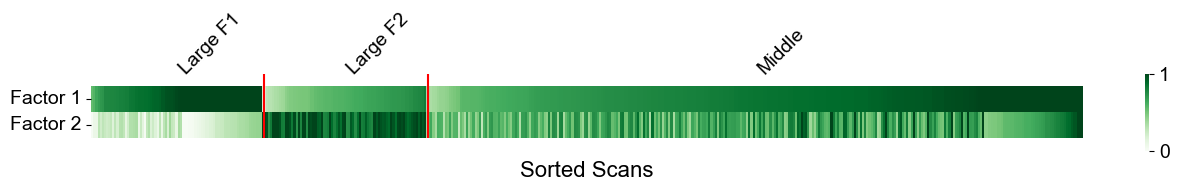

In [68]:
plot_W_heatmap(W, clusters_info=clusters_info, scan_order=sort_clf1f2_idx, cmap='Greens')

In [69]:
f=pn.Row(W.loc[sort_clf1f2_idx].reset_index(drop=True).hvplot.heatmap(cmap='Greens', ylabel='Scans', width=250, height=500, fontscale=1.2, clim=(0,1)).opts( colorbar_opts={'title':'W Matrix'}, xrotation=90, toolbar=None))
f.save('./figures/W_sorted.png')
f

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=250)

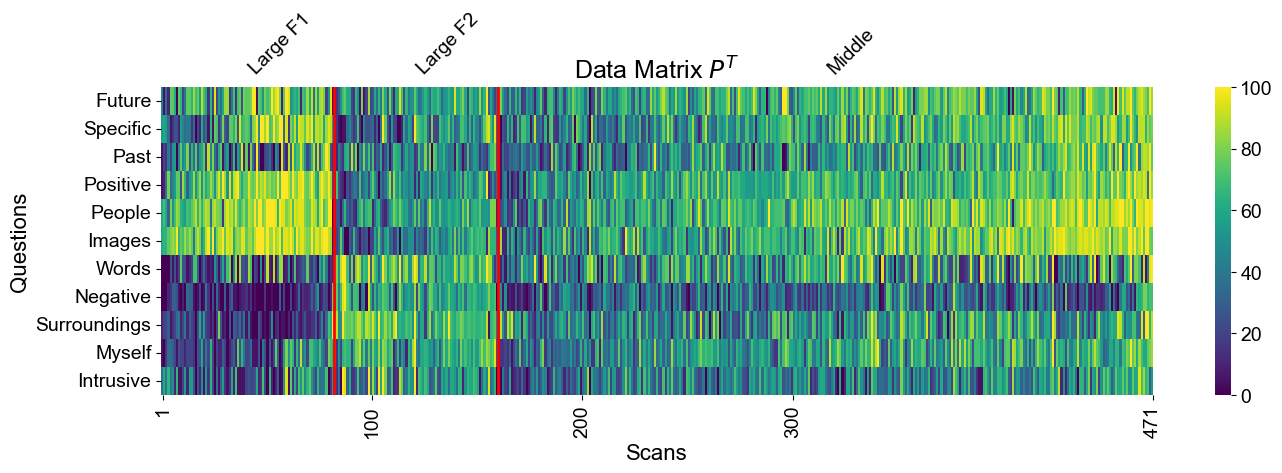

In [70]:
plot_P(SNYCQ, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)

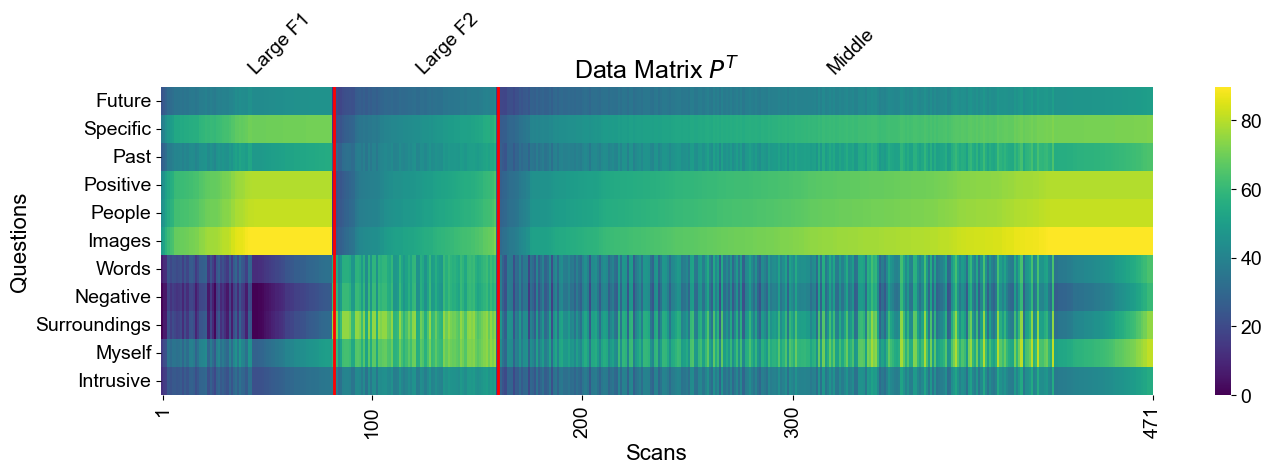

In [71]:
plot_P(Precon, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)

In [72]:
aux = pd.concat([W,clusters_info],axis=1)
aux.hvplot.scatter(x='Factor 1', y='Factor 2', c='Cluster Label', aspect='square', cmap=['lightblue','#ff9999','orange']) + \
aux.hvplot.kde(y='Factor 2', by='Cluster Label', width=500) + aux.hvplot.kde(y='Factor 1', by='Cluster Label', width=500)

:Layout
   .Scatter.I    :Scatter   [Factor 1]   (Factor 2,Cluster Label)
   .NdOverlay.I  :NdOverlay   [Cluster Label]
      :Distribution   [Factor 2]   (Density)
   .NdOverlay.II :NdOverlay   [Cluster Label]
      :Distribution   [Factor 1]   (Density)

In [73]:
clusters_info.to_csv(SNYCQ_CLUSTERS_INFO_PATH)
print('++ INFO: Clustering Membership Info saved to [%s]' % SNYCQ_CLUSTERS_INFO_PATH)

++ INFO: Clustering Membership Info saved to [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/snycq/SNYCQ_clusters_info.csv]


***

# Significant Differences in things of interest across extreme clusters

In [74]:
scans_of_interest = clusters_info[clusters_info['Cluster Label']!='Middle'].index

In [75]:
df = pd.DataFrame(index = scans_of_interest,columns=['Cluster Label','Rel. Motion (mean)','Rel. Motion (max)','Vigilance','Age','Gender'])

In [76]:
_,_,aux_snycq = get_sbj_scan_list(when='post_motion')

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


In [77]:
for scan in df.index:
    df.loc[scan,'Vigilance'] = aux_snycq.loc[scan,'Vigilance']
    df.loc[scan,'Cluster Label'] = clusters_info.loc[scan,'Cluster Label']
df = df.infer_objects()

In [79]:
df.hvplot.kde(y='Vigilance',by='Cluster Label', alpha=.5, title='Vigilance', color=['#4472C4','#ED7D31'], width=500).opts(legend_position='top_left')

:NdOverlay   [Cluster Label]
   :Distribution   [Vigilance]   (Density)

In [80]:
ttest_ind(df.set_index('Cluster Label').loc['Large F1','Vigilance'],df.set_index('Cluster Label').loc['Large F2','Vigilance'],alternative='two-sided')

Ttest_indResult(statistic=0.1624613787828161, pvalue=0.8711514489317592)

In [81]:
mannwhitneyu(df.set_index('Cluster Label').loc['Large F1','Vigilance'],df.set_index('Cluster Label').loc['Large F2','Vigilance'],alternative='two-sided')

MannwhitneyuResult(statistic=3184.5, pvalue=0.9312493425517473)

In [82]:
for scan in df.index:
    sbj,run = scan
    _,_,_,_,run_num,_,run_acq = run.split('-')
    path = osp.join(DATA_DIR,'PrcsData',sbj,'preprocessed','func','pb01_moco','_scan_id_ses-02_task-rest_acq-{run_acq}_run-{run_num}_bold'.format(run_num=run_num,run_acq=run_acq),'rest_realigned_rel.rms')
    mot  = np.loadtxt(path)
    df.loc[scan,'Rel. Motion (mean)'] = mot.mean()
    df.loc[scan,'Rel. Motion (max)']  = mot.max()

In [83]:
df = df.infer_objects()

In [84]:
(df.hvplot.kde(y='Rel. Motion (mean)',by='Cluster Label', alpha=.5, title='Rel. Motion (mean)',color=['#4472C4','#ED7D31'], width=500).opts(legend_position='top_left') + \
df.hvplot.kde(y='Rel. Motion (max)',by='Cluster Label', alpha=.5, title='Rel. Motion (max)',color=['#4472C4','#ED7D31'], width=500).opts(legend_position='top_right')).cols(1)

:Layout
   .NdOverlay.I  :NdOverlay   [Cluster Label]
      :Distribution   [Rel. Motion (mean)]   (Density)
   .NdOverlay.II :NdOverlay   [Cluster Label]
      :Distribution   [Rel. Motion (max)]   (Density)

In [63]:
ttest_ind(df.set_index('Cluster Label').loc['Large F1','Rel. Motion (mean)'],df.set_index('Cluster Label').loc['Large F2','Rel. Motion (mean)'],alternative='two-sided')

Ttest_indResult(statistic=-0.6065857705306705, pvalue=0.5450019704419318)

In [64]:
ttest_ind(df.set_index('Cluster Label').loc['Large F1','Rel. Motion (max)'],df.set_index('Cluster Label').loc['Large F2','Rel. Motion (max)'],alternative='two-sided')

Ttest_indResult(statistic=0.8135421758846505, pvalue=0.41713936351022984)

***

# END OF CODE OF INTEREST SO FAR

In [6]:
clusters_info =pd.read_csv(SNYCQ_CLUSTERS_INFO_PATH, index_col=['Subject','Run'])

In [7]:
clusters_info

Cluster ID Cluster Label
Subject    Run                                                
sub-010014 post-ses-02-run-01-acq-AP           3        Middle
           post-ses-02-run-01-acq-PA           3        Middle
           post-ses-02-run-02-acq-AP           2      Large F2
           post-ses-02-run-02-acq-PA           2      Large F2
sub-010080 post-ses-02-run-02-acq-AP           3        Middle
...                                          ...           ...
sub-010077 post-ses-02-run-02-acq-AP           1      Large F1
           post-ses-02-run-02-acq-PA           3        Middle
sub-010078 post-ses-02-run-01-acq-PA           3        Middle
           post-ses-02-run-02-acq-AP           3        Middle
           post-ses-02-run-02-acq-PA           3        Middle

[471 rows x 2 columns]

In [9]:
clusters_info.reset_index().set_index('Cluster Label').loc['Large F1']

,Subject,Run,Cluster ID
Cluster Label,,,
Large F1,sub-010080,post-ses-02-run-02-acq-PA,1
Large F1,sub-010098,post-ses-02-run-01-acq-PA,1
Large F1,sub-010098,post-ses-02-run-02-acq-AP,1
Large F1,sub-010101,post-ses-02-run-01-acq-AP,1
Large F1,sub-010018,post-ses-02-run-01-acq-AP,1
...,...,...,...
Large F1,sub-010071,post-ses-02-run-02-acq-PA,1
Large F1,sub-010072,post-ses-02-run-02-acq-PA,1
Large F1,sub-010077,post-ses-02-run-01-acq-AP,1


***
# Manual Clustering - Option 1

In [32]:
f1_33 = W['Factor 1'].quantile(.33)
f1_66 = W['Factor 1'].quantile(.66)
f2_33 = W['Factor 2'].quantile(.33)
f2_66 = W['Factor 2'].quantile(.66)
G1 = W.loc[(W['Factor 1'] >= f1_66) & (W['Factor 2'] <= f2_33)]
G2 = W.loc[(W['Factor 1'] <= f1_33) & (W['Factor 2'] >= f2_66)]

In [33]:
line_opts = {'line_dash':'dashed', 'line_color':'gray', 'line_width':1}
W.hvplot.scatter(x='Factor 1', y = 'Factor 2', aspect='square', c='k') * \
hv.HLine(f2_33).opts(**line_opts) * hv.HLine(f2_66).opts(**line_opts) * hv.VLine(f1_33).opts(**line_opts) * hv.VLine(f1_66).opts(**line_opts) * \
G1.hvplot.scatter(x='Factor 1',y='Factor 2', c='lightblue', aspect='square') * \
G2.hvplot.scatter(x='Factor 1',y='Factor 2', c='#ff9999', aspect='square')

:Overlay
   .Scatter.I   :Scatter   [Factor 1]   (Factor 2)
   .HLine.I     :HLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .Scatter.II  :Scatter   [Factor 1]   (Factor 2)
   .Scatter.III :Scatter   [Factor 1]   (Factor 2)

In [34]:
print('++ INFO: Sizes of manually generated groups: G1=%d | G2=%d' % (G1.shape[0], G2.shape[0]))

++ INFO: Sizes of manually generated groups: G1=78 | G2=82


In [35]:
G1 = W.loc[(W['Factor 1'] >= 0.6) & (W['Factor 2'] <= 0.4)]
G2 = W.loc[(W['Factor 1'] <= 0.4) & (W['Factor 2'] >= 0.6)]

In [36]:
line_opts = {'line_dash':'dashed', 'line_color':'gray', 'line_width':1}
W.hvplot.scatter(x='Factor 1', y = 'Factor 2', aspect='square', c='k') * \
hv.HLine(0.4).opts(**line_opts) * hv.HLine(0.6).opts(**line_opts) * hv.VLine(0.4).opts(**line_opts) * hv.VLine(0.6).opts(**line_opts) * \
G1.hvplot.scatter(x='Factor 1',y='Factor 2', c='lightblue', aspect='square', xlim=(0,1), ylim=(0,1)) * \
G2.hvplot.scatter(x='Factor 1',y='Factor 2', c='#ff9999', aspect='square', xlim=(0,1), ylim=(0,1))

:Overlay
   .Scatter.I   :Scatter   [Factor 1]   (Factor 2)
   .HLine.I     :HLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .Scatter.II  :Scatter   [Factor 1]   (Factor 2)
   .Scatter.III :Scatter   [Factor 1]   (Factor 2)

In [37]:
print('++ INFO: Sizes of manually generated groups: G1=%d | G2=%d' % (G1.shape[0], G2.shape[0]))

++ INFO: Sizes of manually generated groups: G1=112 | G2=17
